In [47]:
import pandas as pd
from pandas_datareader import data
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')

# The stochastic oscillator is calculated using the following formula:

%K = 100(C – L14)/(H14 – L14)

Where:

C = the most recent closing price

L14 = the low of the 14 previous trading sessions

H14 = the highest price traded during the same 14-day period

%K= the current market rate for the currency pair

%D = 3-period moving average of %K

In [48]:
def create_stochastic_oscillator(stock_data):
    stock_data['L14'] = stock_data['Low'].rolling(window=14).min()
    stock_data['H14'] = stock_data['High'].rolling(window=14).max()
    stock_data['%K'] = 100*((stock_data['Close'] - stock_data['L14']) / (stock_data['H14'] - stock_data['L14']))
    stock_data['%D'] = stock_data['%K'].rolling(window=3).mean()
    return stock_data

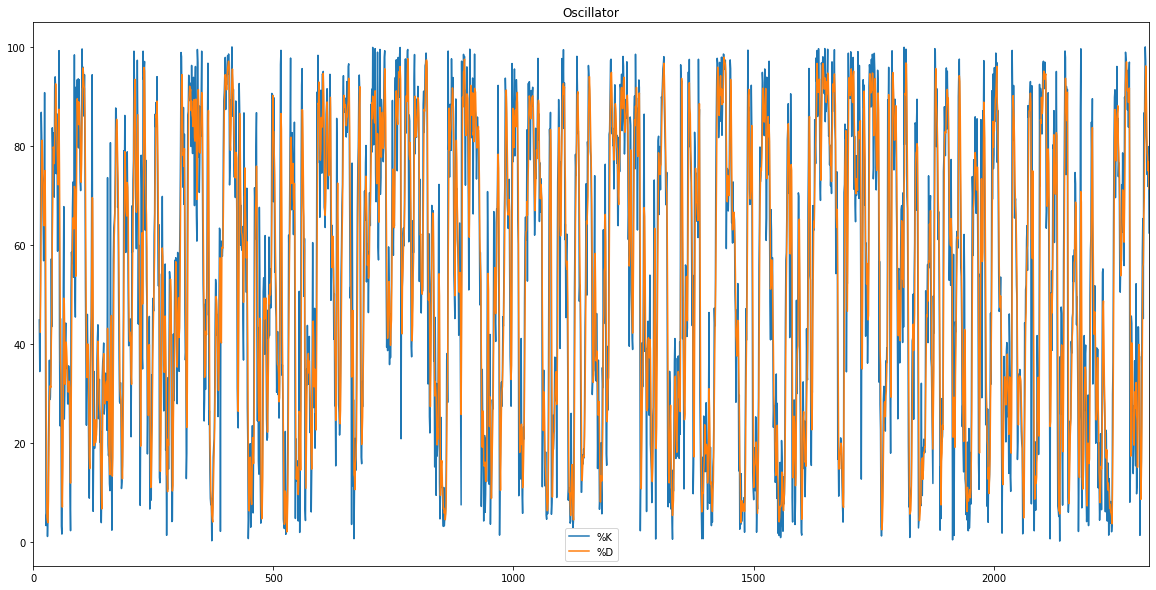

In [60]:
def draw_stochastic_oscillator(stock_data):
    fig, axes = plt.subplots(figsize=(20,10))   
    stock_data[['%K','%D']].plot(ax=axes); axes.set_title('Oscillator')
    plt.show()
    
draw_stochastic_oscillator(stock_data)

In [61]:
 def calculate_long_short(stock_data):   
    
    # Create a column showing "TRUE" if sell entry signal is given and "FALSE" otherwise. 
    # A sell is initiated when the %K line crosses down through the %D line and the value of the oscillator is above 80 
    stock_data['Sell Entry'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) & (stock_data['%D'] > 80)

    #Create a column in the DataFrame showing "TRUE" if sell exit signal is given and "FALSE" otherwise. 
    #A sell exit signal is given when the %K line crosses back up through the %D line 
    stock_data['Sell Exit'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) 

    #create a placeholder column to populate with short positions (-1 for short and 0 for flat) using boolean values created above 
    stock_data['Short'] = np.nan 
    stock_data.loc[stock_data['Sell Entry'],'Short'] = -1 
    stock_data.loc[stock_data['Sell Exit'],'Short'] = 0 


    #Set initial position on day 1 to flat 
    stock_data['Short'][0] = 0 

    #Forward fill the position column to represent the holding of positions through time 
    stock_data['Short'] = stock_data['Short'].fillna(method='pad') 

    #Create a column in stock_data showing "TRUE" if buy entry signal is given and "FALSE" otherwise. 
    #A buy is initiated when the %K line crosses up through the %D line and the value of the oscillator is below 20 
    stock_data['Buy Entry'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) & (stock_data['%D'] < 20) 

    #Create a column in stock_data showing "TRUE" if buy exit signal is given and "FALSE" otherwise. 
    #A buy exit signal is given when the %K line crosses back down through the %D line 
    stock_data['Buy Exit'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) 


    #create a placeholder column to polulate with long positions (1 for long and 0 for flat) using boolean values created above 
    stock_data['Long'] = np.nan  
    stock_data.loc[stock_data['Buy Entry'],'Long'] = 1  
    stock_data.loc[stock_data['Buy Exit'],'Long'] = 0

    #Set initial position on day 1 to flat 
    stock_data['Long'][0] = 0  

    #Forward fill the position column to represent the holding of positions through time 
    stock_data['Long'] = stock_data['Long'].fillna(method='pad') 

    #Add Long and Short positions together to get final strategy position (1 for long, -1 for short and 0 for flat) 
    stock_data['Position'] = stock_data['Long'] + stock_data['Short']
    
    return stock_data

In [51]:
def draw_long_short(stock_data):
    stock_data['Position'].plot(figsize=(20,10))

In [52]:
def draw_strategy_vs_market_return(stock_data):
    #Set up a column holding the daily Tesla returns
    stock_data['Market Returns'] = stock_data['Close'].pct_change()

    #Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
    #of business the previous day
    stock_data['Strategy Returns'] = stock_data['Market Returns'] * stock_data['Position'].shift(1)

    #Finally plot the strategy returns versus Apple returns
    stock_data[['Strategy Returns','Market Returns']].cumsum().plot()

In [53]:
def draw_buy_sell_entry(stock_data):
    stock_data['Sell Entry'] = ((stock_data['%K'] < stock_data['%D']) & (stock_data['%K'].shift(1) > stock_data['%D'].shift(1))) & (stock_data['%D'] > 80)
    stock_data['Buy Entry'] = ((stock_data['%K'] > stock_data['%D']) & (stock_data['%K'].shift(1) < stock_data['%D'].shift(1))) & (stock_data['%D'] < 20)
    #Create empty "Position" column
    stock_data['Position'] = np.nan 
    #Set position to -1 for sell signals
    stock_data.loc[stock_data['Sell Entry'],'Position'] = -1 
    #Set position to -1 for buy signals
    stock_data.loc[stock_data['Buy Entry'],'Position'] = 1 
    #Set starting position to flat (i.e. 0)
    stock_data['Position'].iloc[0] = 0 
    #Forward fill the position column to show holding of positions through time
    stock_data['Position'] = stock_data['Position'].fillna(method='ffill')
    #Set up a column holding the daily Apple returns
    stock_data['Market Returns'] = stock_data['Close'].pct_change()
    #Create column for Strategy Returns by multiplying the daily Apple returns by the position that was held at close
    #of business the previous day
    stock_data['Strategy Returns'] = stock_data['Market Returns'] * stock_data['Position'].shift(1)
    #Finally plot the strategy returns versus Apple returns
    stock_data[['Strategy Returns','Market Returns']].cumsum().plot(figsize=(20,10))

In [54]:
def make_predictions(stock_data):
    list_vol_avg = [stock_data.iloc[99].Volume]
    vol_avg = int(np.mean(stock_data.iloc[:100].Volume))
    for i in range(100, len(stock_data)):
        q1 = np.percentile(stock_data.iloc[:i].Volume, 25)
        q3 = np.percentile(stock_data.iloc[:i].Volume, 75)
        iqr = (q3 - q1) * 1.5
        if (stock_data.iloc[i].Volume < q1 - iqr) or (stock_data.iloc[i].Volume > q3 + iqr):
            stock_data.set_value(i, 'Outlier', 1)
            
            
        if (stock_data.iloc[i].Outlier == 1 and stock_data.iloc[i].Long == 1):
            #stock_data.iloc[i].Prediction = 1
            stock_data.set_value(i, 'Prediction', 1)
            
        if (stock_data.iloc[i].Outlier == 1 and stock_data.iloc[i].Short == -1):
            #stock_data.iloc[i].Prediction = -1
            stock_data.set_value(i, 'Prediction', -1)
            
        vol_avg = int(np.mean(stock_data.iloc[:i].Volume))
        list_vol_avg.append(vol_avg)
    return stock_data

In [55]:
def main():
    stock_data = pd.read_csv(os.getcwd() + "/Stock_Data/TSLA.csv")
    stock_data['Date'] = pd.to_datetime(stock_data['Date'])
    stock_data = stock_data.sort_values(by='Date')
    stock_data = stock_data.dropna()
    stock_data['Outlier'] = 0
    stock_data['Prediction'] = 0
    stock_data.info()
    stock_data.describe()
    stock_data.head()
    stock_data = create_stochastic_oscillator(stock_data)
    stock_data = calculate_long_short(stock_data)
    stock_data = make_predictions(stock_data)
    return stock_data
    
stock_data = main()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2324 entries, 0 to 2323
Data columns (total 9 columns):
Date          2324 non-null datetime64[ns]
Open          2324 non-null float64
High          2324 non-null float64
Low           2324 non-null float64
Close         2324 non-null float64
Adj Close     2324 non-null float64
Volume        2324 non-null int64
Outlier       2324 non-null int64
Prediction    2324 non-null int64
dtypes: datetime64[ns](1), float64(5), int64(3)
memory usage: 181.6 KB


In [56]:
stock_data.Long.value_counts()

0.0    1921
1.0     403
Name: Long, dtype: int64

In [57]:
stock_data.Outlier.value_counts()

0    2000
1     324
Name: Outlier, dtype: int64

In [58]:
stock_data.Prediction.value_counts()

 0    2214
-1      70
 1      40
Name: Prediction, dtype: int64

In [59]:
stock_data.head()

Date       Open   High        Low      Close  Adj Close    Volume  \
0 2010-06-29  19.000000  25.00  17.540001  23.889999  23.889999  18766300   
1 2010-06-30  25.790001  30.42  23.299999  23.830000  23.830000  17187100   
2 2010-07-01  25.000000  25.92  20.270000  21.959999  21.959999   8218800   
3 2010-07-02  23.000000  23.10  18.709999  19.200001  19.200001   5139800   
4 2010-07-06  20.000000  20.00  15.830000  16.110001  16.110001   6866900   

   Outlier  Prediction  L14  H14  %K  %D  Sell Entry  Sell Exit  Short  \
0        0           0  NaN  NaN NaN NaN       False      False    0.0   
1        0           0  NaN  NaN NaN NaN       False      False    0.0   
2        0           0  NaN  NaN NaN NaN       False      False    0.0   
3        0           0  NaN  NaN NaN NaN       False      False    0.0   
4        0           0  NaN  NaN NaN NaN       False      False    0.0   

   Buy Entry  Buy Exit  Long  Position  
0      False     False   0.0       0.0  
1      False     False   0.0       0.0  
2      False     False   0.0       0.0  
3      False     False   0.0       0.0  
4      False     False   0.0       0.0